'Signal audio sous forme de tableau Numpy : \n'

array([-4.5776367e-04, -8.0871582e-04, -1.1444092e-03, ...,
       -1.5258789e-05,  4.5776367e-05,  1.5258789e-04],
      shape=(960000,), dtype=float32)

Fréquence d'échantillonage :  3200 Hertz


array([[6.29924238e-03, 2.22601835e-02, 2.04977598e-02, ...,
        2.57789344e-02, 2.50464492e-02, 1.72800217e-02],
       [2.28954144e-02, 3.43959592e-02, 9.44766030e-03, ...,
        1.22478325e-02, 1.54856090e-02, 1.12288604e-02],
       [3.19853984e-02, 4.84238975e-02, 4.92913201e-02, ...,
        1.09378900e-02, 9.51807946e-03, 1.70962501e-03],
       ...,
       [2.91044125e-05, 1.95266795e-04, 2.49577191e-04, ...,
        5.72717909e-05, 1.81373107e-04, 2.05267483e-04],
       [2.22495539e-04, 3.49072856e-04, 2.75735190e-04, ...,
        1.35912967e-04, 2.00484443e-04, 2.42953523e-04],
       [3.23440618e-04, 4.27916180e-04, 1.08678141e-04, ...,
        1.21595753e-04, 6.58162098e-05, 2.30087666e-04]],
      shape=(1025, 1876), dtype=float32)

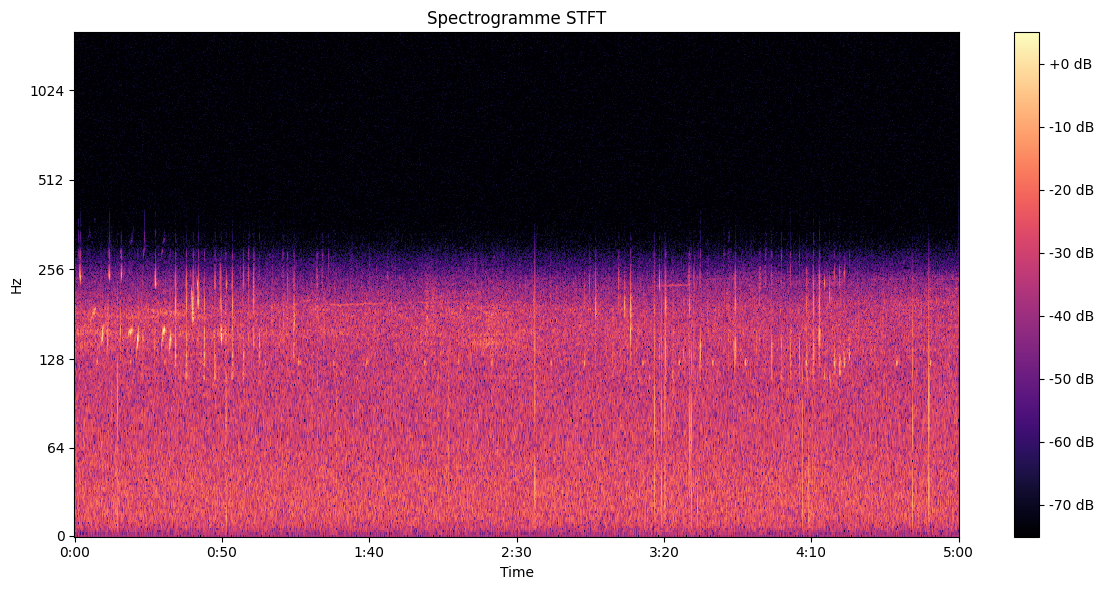

In [ ]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt

#Question 1 

def load_signal(filename):
    signal, frequence_echantillonage = librosa.load(filename, sr=None)
    # frequence_echantillonage = librosa.get_samplerate(filename)
    display("Signal audio sous forme de tableau Numpy : \n", signal)
    print("Fréquence d'échantillonage : ",frequence_echantillonage, "Hertz")
    return signal, frequence_echantillonage

def get_spectro(signal, type):
    return np.abs(librosa.stft(signal, window=type))

def show_spectro(sr, spectre):
    spectre_db = librosa.amplitude_to_db(spectre)

    plt.figure(figsize=(12, 6))

    librosa.display.specshow(
        spectre_db,
        sr=sr,
        y_axis="log",
        x_axis="time",
    )

    plt.title("Spectrogramme STFT")
    plt.colorbar(format="%+2.0f dB")
    plt.tight_layout()
    plt.show()



filename = 'ValabFr-20221128_133055.735.flac'
signal, frequence_echantillonage = load_signal(filename)
spectre = get_spectro(signal, "hann")
display(spectre)
show_spectro(frequence_echantillonage, spectre)





# Question 2

Pour cela il faut régler les paramètres n_fft et hop_length dans la fonction librosa.stft et offset et duration de librosa.load

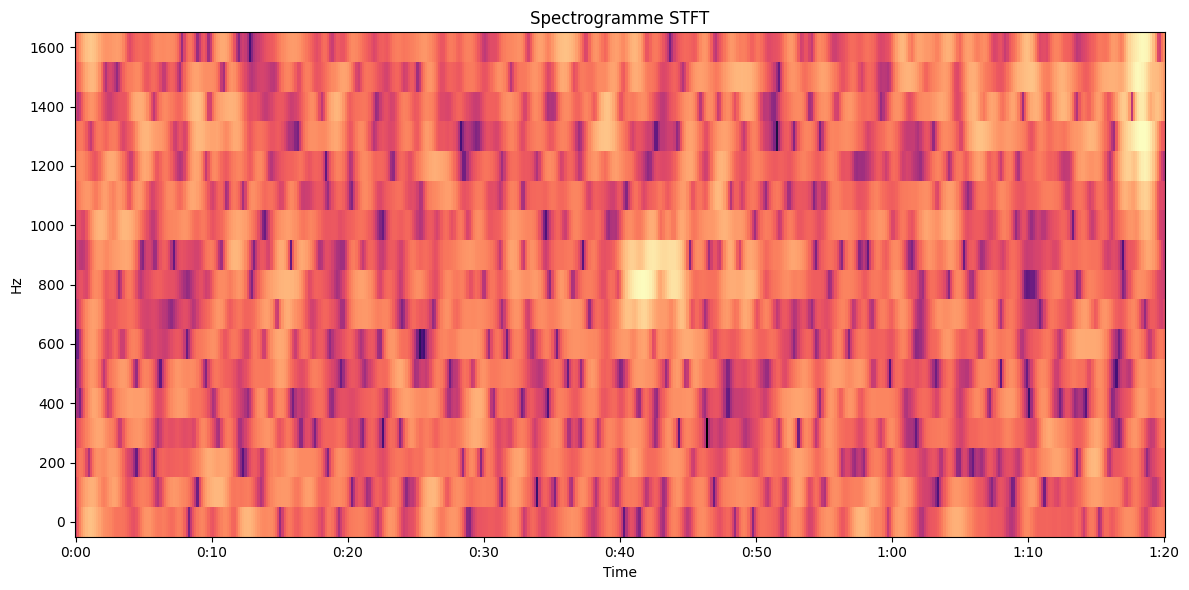

In [2]:
def load_signal(filename, offset=0, duration=10):
    signal, frequence_echantillonage = librosa.load(filename, offset=offset, duration=duration, sr=None)
    return signal, frequence_echantillonage

def get_spectro(signal, frequence_echantillonage, fmin, fmax, n_fft, hop_length, type):
    signal = np.abs(librosa.stft(signal, n_fft=n_fft, hop_length=hop_length, window=type))
    tab_freq = librosa.fft_frequencies(sr=frequence_echantillonage, n_fft=n_fft)

    indice_min = np.searchsorted(tab_freq, fmin, 'left')
    indice_max = np.searchsorted(tab_freq, fmax, 'right')

    spectre = signal[indice_min:indice_max, :]

    return spectre

def show_spectro(sr, spectre):
    spectre_db = librosa.amplitude_to_db(spectre)

    plt.figure(figsize=(12, 6))

    librosa.display.specshow(
        spectre_db,
        sr=sr,
        x_axis="time",
        y_axis="hz"
    )

    plt.title("Spectrogramme STFT")
    plt.tight_layout()
    plt.show()

n_fft = 1024
hop_length = 64


nv_signal, frequence_echantillonage = load_signal(filename)
nv_spectre = get_spectro(nv_signal,frequence_echantillonage, 100, 150, n_fft, hop_length, 'hann')
show_spectro(frequence_echantillonage, nv_spectre)






# Question 3

                           filename  conf  Begin Time (s)  End Time (s)  \
0  ValabFr-20221128_133055.735.flac   1.0        4.741538       5.69581   

   Low Freq (Hz)  High Freq (Hz)       snr  
0        115.663         135.749  0.756145  


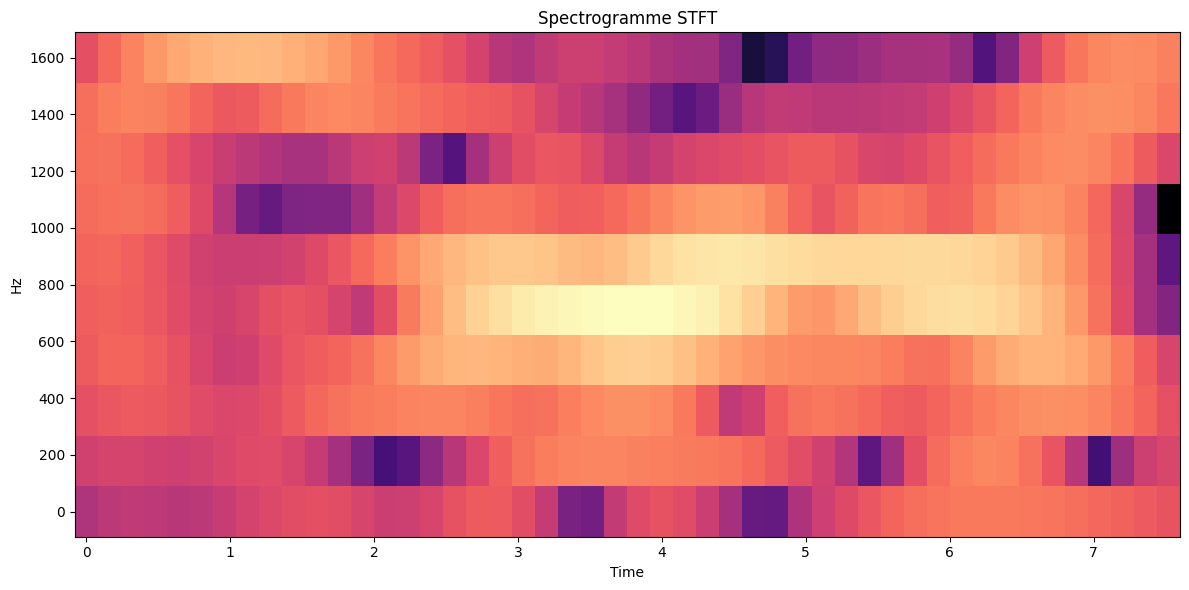

In [3]:
import pandas as pd

df = pd.read_csv("detections.csv")
target = "ValabFr-20221128_133055.735.flac"
result = df[df["filename"] == target]
print(result.head(1))

row = result.head(1).to_numpy()[0]

offset = row[2]
start  = row[3]
fmin   = row[4] - 5
fmax   = row[5] + 5
duration = start - offset

nv_signal, frequence_echantillonage = load_signal(
    filename=target,
    offset=offset,
    duration=duration
)

nv_spectre = get_spectro(
    nv_signal,
    frequence_echantillonage,
    fmin,
    fmax,
    1024,
    hop_length,
    "hann"
)

show_spectro(frequence_echantillonage, nv_spectre)





## Question 4 – Décalage temporel aléatoire

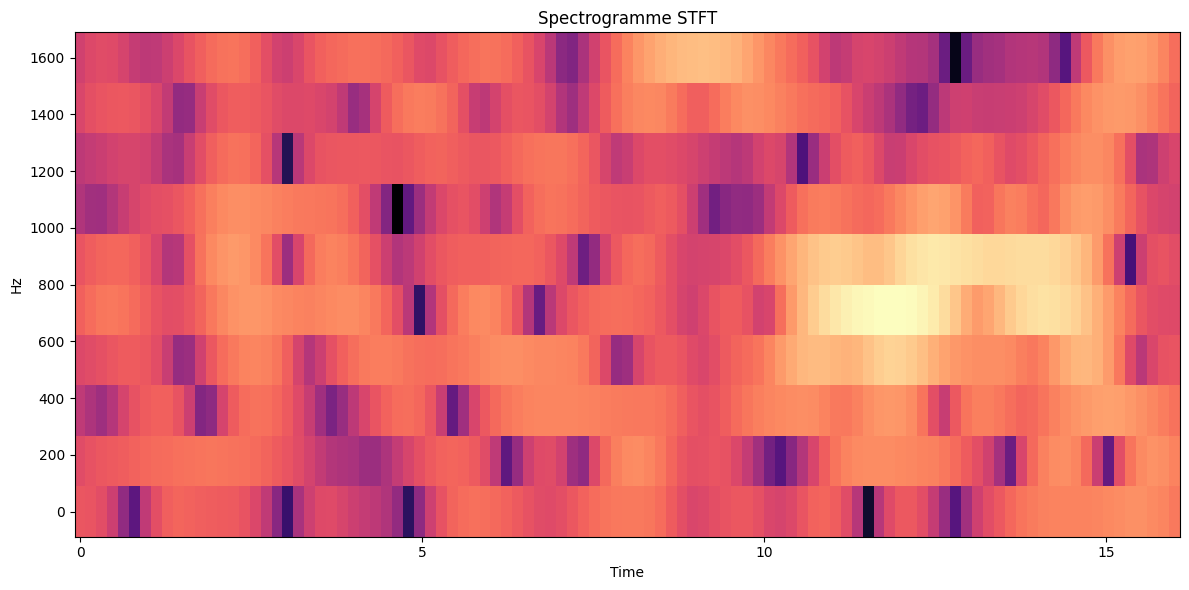

In [4]:
import random as rd

target = "ValabFr-20221128_133055.735.flac"

def shift_signal(signal, pulse_offset, pulse_duration, window_duration, fs):
    pulse_samples = int(pulse_duration * fs)
    window_samples = int(window_duration * fs)
    signal_samples = len(signal)

    max_start_in_window = window_samples - pulse_samples
    pulse_pos_in_window = rd.randint(0, max_start_in_window)

    window_start = int(pulse_offset * fs) - pulse_pos_in_window
    window_start = max(0, min(signal_samples - window_samples, window_start))

    return signal[window_start : window_start + window_samples]
    

def get_pulses(target, n_fft, hop_length, window_duration):
    df = pd.read_csv("detections.csv")
    result = df[df["filename"] == target]

    all_pulses = []

    signal_complet, freq_complet = load_signal(filename=target, offset=0, duration=None)

    for _, row in result.iterrows():
        offset = row["Begin Time (s)"]
        start = row["End Time (s)"]
        fmin = row["Low Freq (Hz)"] - 5
        fmax = row["High Freq (Hz)"] + 5
        duration = start - offset

        nv_signal = shift_signal(
            signal=signal_complet,
            pulse_offset=offset,
            pulse_duration=duration,
            window_duration=window_duration,
            fs=freq_complet
        )

        nv_spectre = get_spectro(
            nv_signal,
            freq_complet,
            fmin,
            fmax,
            n_fft,
            hop_length,
            "hann"
        )

        all_pulses.append(nv_spectre)
    return all_pulses

all_pulses = get_pulses(target=target, n_fft=1024, hop_length=64, window_duration=2)

# for spectre in all_pulses:
#     show_spectro(frequence_echantillonage, spectre)

show_spectro(frequence_echantillonage, all_pulses[0])


Selon moi, le décentrage du pulse est pertinent car il permet d'entraîner notre modèle sur des données plus réalistes car les pulses ne seront pas forcément au milieu à chaque fois.

## Question 5 : Agrégation des pulses (positifs)

In [5]:
N_FFT = 1024
HOP_LENGTH = 64
WINDOW_DURATION = 2.0
FMIN = 120
FMAX = 130
WINDOW = "hann"

def get_spectros_pos_one_file(filename, df, window_duration=WINDOW_DURATION, n_fft=N_FFT, hop_length=HOP_LENGTH):
    result = df[df["filename"] == filename]
    if result.empty:
        return np.empty((0, 0, 0))

    signal, sr = load_signal(filename, offset=0, duration=None)
    spectros = []

    for _, row in result.iterrows():
        offset = row["Begin Time (s)"]
        duration = row["End Time (s)"] - offset

        nv_signal = shift_signal(signal, offset, duration, window_duration, sr)
        nv_spectre = get_spectro(nv_signal, sr, FMIN, FMAX, n_fft, hop_length, WINDOW)

        spectros.append(nv_spectre)

    return np.stack(spectros, axis=0)


def get_all_spectros_pos(df, window_duration=WINDOW_DURATION, n_fft=N_FFT, hop_length=HOP_LENGTH):
    all_spectros = []

    for filename in df["filename"].unique():
        spectros = get_spectros_pos_one_file(
            filename, df, window_duration, n_fft, hop_length
        )
        if spectros.size > 0:
            all_spectros.append(spectros)

    return np.concatenate(all_spectros, axis=0)


df = pd.read_csv('detections.csv')
spectros_one_file = get_spectros_pos_one_file(target, df)
print(f"Spectrogrammes pour {target}: shape={spectros_one_file.shape}")

all_spectros = get_all_spectros_pos(df)
print(f"\nTotal spectrogrammes positifs: shape={all_spectros.shape}")

Spectrogrammes pour ValabFr-20221128_133055.735.flac: shape=(32, 3, 101)

Total spectrogrammes positifs: shape=(106, 3, 101)


## Question 6 – Génération automatique des annotations négatives

In [6]:
def generate_negative(filename, df, window_duration=WINDOW_DURATION, n_fft=N_FFT, hop_length=HOP_LENGTH):
    signal, sr = load_signal(filename, offset=0, duration=None)

    window_samples = int(window_duration * sr)
    signal_samples = len(signal)

    max_start = signal_samples - window_samples
    if max_start <= 0:
        raise ValueError("Signal trop court")

    annotations = df[df["filename"] == filename][["Begin Time (s)", "End Time (s)"]].to_numpy()
    
    while True:
        start_sample = np.random.randint(0, max_start + 1)
        start_time = start_sample / sr
        end_time = start_time + window_duration

        valid = True
        for begin, end in annotations:
            if not (end_time <= begin or start_time >= end):
                valid = False
                break

        if not valid:
            continue

        window = signal[start_sample:start_sample + window_samples]

        spectro = get_spectro(window,sr,FMIN,FMAX, n_fft,hop_length, WINDOW)
        
        return spectro


neg_spectro = generate_negative(target, df)
print(neg_spectro)



[[0.0181241  0.02044101 0.0215224  0.02094984 0.01870969 0.01534243
  0.01195429 0.00964099 0.00892778 0.00978216 0.01276332 0.01687616
  0.02000351 0.0207699  0.01945455 0.01647075 0.01346373 0.01328949
  0.01789665 0.02387938 0.02802426 0.02967636 0.03027772 0.03157071
  0.03363491 0.03473651 0.03415719 0.03129966 0.02671103 0.02241149
  0.02007195 0.01892472 0.01839579 0.01741777 0.01580878 0.01428075
  0.01291311 0.01183789 0.01090699 0.00958021 0.00758185 0.00582234
  0.00508483 0.00575584 0.00813362 0.01104697 0.01314593 0.01475262
  0.01611623 0.01652491 0.0160314  0.01481978 0.01271707 0.01020291
  0.00928294 0.01144922 0.01505525 0.01839503 0.02144925 0.02405507
  0.02613621 0.02800199 0.0295955  0.03072346 0.031506   0.03105937
  0.0287055  0.02472801 0.01937462 0.01266833 0.00732024 0.00874897
  0.01364662 0.01740249 0.01997201 0.0212536  0.02167473 0.02229242
  0.02323974 0.02390775 0.02439064 0.0254675  0.02675091 0.02846733
  0.03082218 0.03299853 0.03419617 0.03454117 0.

## Question 7 – Agrégation des non-pulses (négatifs)

In [7]:
def get_spectros_neg_one_file(filename, df, N,
                              window_duration=WINDOW_DURATION,
                              fmin=FMIN, fmax=FMAX,
                              n_fft=N_FFT, hop_length=HOP_LENGTH):
    spectros = []
    for _ in range(N):
        spectro = generate_negative(filename, df,
                                    window_duration=window_duration,
                                    n_fft=n_fft,
                                    hop_length=hop_length)
        if spectro is not None:
            spectros.append(spectro)

    if spectros:
        return np.stack(spectros, axis=0)
    else:
        return np.empty((0,0,0))


def get_all_spectros_neg(df,
                         window_duration=WINDOW_DURATION,
                         fmin=FMIN, fmax=FMAX,
                         n_fft=N_FFT, hop_length=HOP_LENGTH):
    all_spectros_neg = []

    for filename in df["filename"].unique():
        n_pos = len(df[df["filename"] == filename])
        spectros_neg = get_spectros_neg_one_file(filename, df, n_pos,
                                                 window_duration,
                                                 fmin, fmax,
                                                 n_fft, hop_length)
        if spectros_neg.size > 0:
            all_spectros_neg.append(spectros_neg)

    if all_spectros_neg:
        return np.concatenate(all_spectros_neg, axis=0)
    else:
        return np.empty((0,0,0))
    
all_neg = get_all_spectros_neg(df)
print(f"Total spectrogrammes négatifs : shape = {all_neg.shape}")



Total spectrogrammes négatifs : shape = (106, 3, 101)


3. Il risque de prédire systématiquement la classe majoritaire (ici, les positifs) car il sera très sensible. On perd alors la fonction a généraliser.

## Question 8 – Agréger les positifs et les négatifs

In [8]:
from pathlib import Path

def generate_dataset(spectros_pos, spectros_neg, output_dir='./'):
    if spectros_pos.size == 0 or spectros_neg.size == 0:
        raise ValueError("Empty positive or negative spectrograms")
    
    X = np.concatenate([spectros_pos, spectros_neg], axis=0)
    Y = np.concatenate([
        np.ones(len(spectros_pos), dtype=np.int32),
        np.zeros(len(spectros_neg), dtype=np.int32)
    ])
    
    permutation = np.random.permutation(len(X))
    X = X[permutation]
    Y = Y[permutation]
    
    output_path = Path(output_dir)
    output_path.mkdir(parents=True, exist_ok=True)
    
    np.save(output_path / 'x.npy', X)
    np.save(output_path / 'y.npy', Y)
    
    print(f"Dataset généré : X={X.shape}, Y={Y.shape}")
    print(f"Positifs: {Y.sum()}, Négatifs: {len(Y) - Y.sum()}")
    
    return X, Y

spectros_pos = get_all_spectros_pos(df)
spectros_neg = get_all_spectros_neg(df)

X, Y = generate_dataset(spectros_pos, spectros_neg)

Dataset généré : X=(212, 3, 101), Y=(212,)
Positifs: 106, Négatifs: 106


## Question 9 – Data augmentation

In [9]:
def get_spectros_pos_one_file(filename, df, window_duration=WINDOW_DURATION, n_fft=N_FFT, hop_length=HOP_LENGTH, K_shifts=1):
    result = df[df["filename"] == filename]
    if result.empty:
        return np.empty((0, 0, 0))

    signal, sr = load_signal(filename, offset=0, duration=None)
    spectros = []

    for _, row in result.iterrows():
        offset = row["Begin Time (s)"]
        duration = row["End Time (s)"] - offset


        for _ in range(K_shifts):
            nv_signal = shift_signal(signal, offset, duration, window_duration, sr)
            
            nv_spectre = get_spectro(nv_signal, sr, FMIN, FMAX, n_fft, hop_length, WINDOW)
            spectros.append(nv_spectre)

    return np.stack(spectros, axis=0)


def get_all_spectros_pos(df, window_duration=WINDOW_DURATION, n_fft=N_FFT, hop_length=HOP_LENGTH, K_shifts=1):
    all_spectros = []

    for filename in df["filename"].unique():
        spectros = get_spectros_pos_one_file(
            filename, df, window_duration, n_fft, hop_length, K_shifts
        )
        if spectros.size > 0:
            all_spectros.append(spectros)

    return np.concatenate(all_spectros, axis=0)

spectros_pos = get_all_spectros_pos(df, K_shifts=3)
print(f"Nombre de spectrogrammes positifs après k-shifts : {spectros_pos.shape[0]}")


Nombre de spectrogrammes positifs après k-shifts : 318


In [11]:
def get_spectros_neg_one_file(filename, df, N,
                              window_duration=WINDOW_DURATION,
                              fmin=FMIN, fmax=FMAX,
                              n_fft=N_FFT, hop_length=HOP_LENGTH):
    spectros = []
    for _ in range(N):
        spectro = generate_negative(filename, df,
                                    window_duration=window_duration,
                                    n_fft=n_fft,
                                    hop_length=hop_length)
        if spectro is not None:
            spectros.append(spectro)

    if spectros:
        return np.stack(spectros, axis=0)
    else:
        return np.empty((0,0,0))

def get_all_spectros_neg(df, K_shifts,
                         window_duration=WINDOW_DURATION,
                         fmin=FMIN, fmax=FMAX,
                         n_fft=N_FFT, hop_length=HOP_LENGTH):
    all_spectros_neg = []

    for filename in df["filename"].unique():
        n_pos = len(df[df["filename"] == filename])
        
        N_samples = n_pos * K_shifts
        
        spectros_neg = get_spectros_neg_one_file(
            filename, df, N_samples,
            window_duration,
            fmin, fmax,
            n_fft, hop_length
        )
        if spectros_neg.size > 0:
            all_spectros_neg.append(spectros_neg)

    if all_spectros_neg:
        return np.concatenate(all_spectros_neg, axis=0)
    else:
        return np.empty((0,0,0))


def get_spectros_pos_one_file(filename, df, K_shifts, window_duration=WINDOW_DURATION, n_fft=N_FFT, hop_length=HOP_LENGTH):
    result = df[df["filename"] == filename]
    if result.empty:
        return np.empty((0, 0, 0))

    signal, sr = load_signal(filename, offset=0, duration=None)
    spectros = []

    for _, row in result.iterrows():
        offset = row["Begin Time (s)"]
        duration = row["End Time (s)"] - offset


        for _ in range(K_shifts):
            nv_signal = shift_signal(signal, offset, duration, window_duration, sr)
            
            nv_spectre = get_spectro(nv_signal, sr, FMIN, FMAX, n_fft, hop_length, WINDOW)
            spectros.append(nv_spectre)

    return np.stack(spectros, axis=0)


def get_all_spectros_pos(df, K_shifts, window_duration=WINDOW_DURATION, n_fft=N_FFT, hop_length=HOP_LENGTH):
    all_spectros = []

    for filename in df["filename"].unique():
        spectros = get_spectros_pos_one_file(
            filename, df, K_shifts, window_duration, n_fft, hop_length
        )
        if spectros.size > 0:
            all_spectros.append(spectros)

    return np.concatenate(all_spectros, axis=0)

K_SHIFTS = 10

spectros_pos = get_all_spectros_pos(df,K_SHIFTS)
spectros_neg = get_all_spectros_neg(df,K_SHIFTS)

X, Y = generate_dataset(spectros_pos, spectros_neg)

Dataset généré : X=(2120, 3, 101), Y=(2120,)
Positifs: 1060, Négatifs: 1060


In [10]:
def get_spectros_pos_one_file(filename, df, window_duration=WINDOW_DURATION, n_fft=N_FFT, hop_length=HOP_LENGTH, K_shifts=1, brown_noise=False):
    result = df[df["filename"] == filename]
    if result.empty:
        return np.empty((0, 0, 0))

    signal, sr = load_signal(filename, offset=0, duration=None)
    spectros = []

    for _, row in result.iterrows():
        offset = row["Begin Time (s)"]
        duration = row["End Time (s)"] - offset


        for _ in range(K_shifts):
            
            nv_signal = shift_signal(signal, offset, duration, window_duration, sr)
            
            if(brown_noise):
                nv_signal = add_brown_noise(nv_signal)
            
            nv_spectre = get_spectro(nv_signal, sr, FMIN, FMAX, n_fft, hop_length, WINDOW)
            spectros.append(nv_spectre)

    return np.stack(spectros, axis=0)


def get_all_spectros_pos(df, window_duration=WINDOW_DURATION, n_fft=N_FFT, hop_length=HOP_LENGTH, K_shifts=1):
    all_spectros = []

    for filename in df["filename"].unique():
        spectros = get_spectros_pos_one_file(
            filename, df, window_duration, n_fft, hop_length
        )
        if spectros.size > 0:
            all_spectros.append(spectros)

    return np.concatenate(all_spectros, axis=0)

# TODO définir la fonction add_brown_noise en important le github https://github.com/Kettukaa/brown-noise/tree/main
def add_brown_noise(signal):
    # Definir brown 
    return signal